# Co-locating Temperature Anomaly Values between CBP Monitoring Stations and Satellite SST

This script creates a csv which holds the corresponding validation data points from both Chesapeake Bay Program's (CBP) Water Quality dataset and the two satellite datasets. The csv contains one row for each day and pixel in which there was a CBP validation point, and either a MUR or a Geopolar satellite pixel.
Output: csv of temperature values that can be observed in the satellite SST datasets and the in situ CBP data

In [1]:
import os
import warnings

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'
SAVE_FIGS = False

## Read CBay Program In Situ Anomaly Data

In [3]:
path = os.path.join(REPO_ROOT, 'data/interim', 'cbp_stations_climatology_anomaly_filtered.csv')
wq = pd.read_csv(path, parse_dates=[1])

#### Probably getting deleted

In [ ]:
wq['SampleDate'] = pd.to_datetime(wq.SampleDate)

**Layer Codes**
from page 33 of [the database schema](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf).
| Code | Meaning|
| :--: | :--: |
| AB | FIXED ABOVE BOTTOM |
| AP | ABOVE PYCNOCLINE |
| B | BOTTOM |
| BP | BELOW PYCNOCLINE |
| BS | FLOATING BELOW SURFACE |
| I | INTEGRATED |
| M | MID-DEPTH |
| M1 | MIDDLE 1/3 OF TOTAL STATION DEPTH |
| M2 | MIDDLE 2/3 OF TOTAL STATION DEPTH |
| S | SURFACE |
| VP | VERTICAL PROFILE |

In [ ]:
# Select only samples taken at mid-depths, below the pycnocline, or as part of a vertical profile
# wq = wq[(wq.Layer == 'BP') | (wq.Layer == 'M') | (wq.Layer == 'M1') | \
#         (wq.Layer == 'M2') | (wq.Layer == 'VP')]

## Filtering to one depth per location (delete)

In [4]:
wq

,Station,SampleDate,MeasureValue,Latitude,Longitude,ClimValue,MeasureAnomaly,geometry
0,CB2.1,2003-01-15,1.10,39.44149,-76.02599,3.138462,-2.038462,POINT (-76.02599 39.44149)
1,CB2.1,2004-01-14,0.30,39.44149,-76.02599,3.138462,-2.838462,POINT (-76.02599 39.44149)
2,CB2.1,2005-01-13,4.90,39.44149,-76.02599,3.138462,1.761538,POINT (-76.02599 39.44149)
3,CB2.1,2006-01-12,4.60,39.44149,-76.02599,3.138462,1.461538,POINT (-76.02599 39.44149)
4,CB2.1,2007-01-12,5.30,39.44149,-76.02599,3.138462,2.161538,POINT (-76.02599 39.44149)
...,...,...,...,...,...,...,...,...
15758,WT8.3,2018-02-15,3.60,38.84250,-76.53410,3.915625,-0.315625,POINT (-76.5341 38.8425)
15759,WT8.3,2019-02-11,3.90,38.84250,-76.53410,3.915625,-0.015625,POINT (-76.5341 38.8425)
15760,WT8.3,2020-02-13,7.00,38.84250,-76.53410,3.915625,3.084375,POINT (-76.5341 38.8425)
15761,WT8.3,2021-02-08,3.30,38.84250,-76.53410,3.915625,-0.615625,POINT (-76.5341 38.8425)


In [5]:
# Filter out anything shallower than 1m and deeper than 3m
# wq = wq[(wq.Depth > 1) & (wq.Depth < 3)]

### Isolating just one depth observation per location

Select one measurement for each location and time, in each case selecting the measurement closest to 2 meters depth.

In [6]:
# def find_correct_depth(df):
#     if len(df) > 1:
#         # Get the row with the depth closest to 2 meters
#         df = df.iloc[(df['Depth']-2).abs().argsort()[:1]]
#     # if there was only 1 row to begin with, just return that one
#     return df

In [7]:
# wq = wq.groupby(['Station', 'SampleDate', 'SampleTime']) \
#                 .apply(find_correct_depth)

In [8]:
# wq.Depth.unique()

### Inspecting the remaining observations

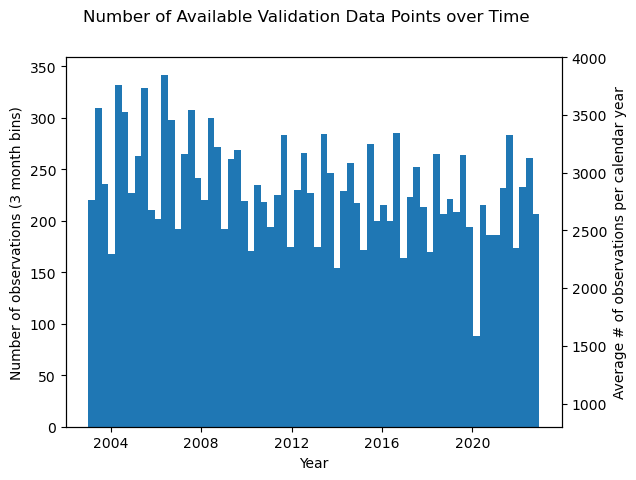

In [9]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylim([800, 4000])

histogram = wq.SampleDate.hist(bins=68, ax=ax1, grid=False)
ax1.set_ylabel('Number of observations (3 month bins)')
ax1.set_xlabel('Year')
# ax1.grid(axis='y', linestyle='--', color='lightgrey')
# ax1.set_yticks(np.arange(100, 900, 100))

# Making the line plot
# didn't work using default pandas .plot(ax=ax2) I think because date range was off
avgs = wq.groupby(wq.SampleDate.dt.year).count().Station.values
year_start = pd.date_range('2003', '2019', freq='YS')
year_end = pd.date_range('2003', '2020', freq='Y')
# ax2.hlines(avgs, year_start, year_end, color='black')
ax2.set_ylabel('Average # of observations per calendar year')
# ax2.set_yticks(np.arange(1200, 3200, 3050))

fig.suptitle('Number of Available Validation Data Points over Time')

if SAVE_FIGS:
    path = os.path.join(REPO_ROOT, 'figures/supplemental', 'validation_points_temporal_histogram.png')
    plt.savefig(path)

## Intersect Operation -- co-locating SST and in situ obs

In [4]:
def get_satellite_sst(full_sst, lat, lon, time):
    '''
    TODO: docstring
    '''
    # time does NOT have nearest interpolation because we do not want adjacent days to
    # be selected
    try:
        matching_array = full_sst.sel(lat=lat, lon=lon, 
                                      method='nearest').sel(time=time.strftime('%Y-%m-%d')).values
        if matching_array.size == 1:
            matching_sst = matching_array[0]
        else:
            matching_sst = np.nan
            warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
    except KeyError:
        # If a key error was raised the corresponding date was not found. Return nan for that sample location
        matching_sst = np.nan
    # print('returning ', matching_sst)
    return matching_sst

In [11]:
wq = wq[['MeasureAnomaly', 'Latitude', 'Longitude', 'SampleDate']]
wq_sst = wq.copy()
wq_sst['geopolar_anom'] = -999
wq_sst['mur_anom'] = -999

In [12]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

path = os.path.join(REPO_ROOT, 'data/interim', 'geopolar_climatology_chesapeake.nc')
geopolar_clim = xr.open_dataset(path).climatology

geopolar_anom = geopolar - geopolar_clim

Timing Notes

Feb 1: ~22,000 rows: ~50 seconds


In [13]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['geopolar_anom'] = wq_sst.apply(lambda x: get_satellite_sst(geopolar_anom, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2018-03-12
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2018-03-12
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2018-03-12
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2018-03-12
  warnings.warn('Match

CPU times: user 19.4 s, sys: 350 ms, total: 19.8 s
Wall time: 20 s


**Step:** fill anomaly column for MUR

In [14]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-20020901_20230831.nc'
)
mur = xr.open_dataset(path).analysed_sst

path = os.path.join(REPO_ROOT, 'data/interim', 'mur_climatology_chesapeake.nc')
mur_clim = xr.open_dataset(path).climatology

mur_anom = mur - mur_clim

In [15]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['mur_anom'] = wq_sst.apply(lambda x: get_satellite_sst(mur_anom, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2022-11-09
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2022-11-09
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2022-11-09
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_40451/3466669827.py:14: UserWarning: Matching array length is not 1. Date is likely missing (?)2022-11-09
  warnings.warn('Match

CPU times: user 19.5 s, sys: 519 ms, total: 20 s
Wall time: 20.2 s


### Cleaning Output

Keep just the rows where either mur or geopolar have values. (Remove the rows where both mur and geopolar are null)

_Do we want an AND or an OR in there?_ --> OR is good. (note the NOT in front of the isnull)

In [16]:
wq_sst = wq_sst[(~wq_sst['mur_anom'].isnull()) | (~wq_sst['geopolar_anom'].isnull())]

In [17]:
wq_sst

,MeasureAnomaly,Latitude,Longitude,SampleDate,geopolar_anom,mur_anom
0,-2.038462,39.44149,-76.02599,2003-01-15,-0.741257,-0.627800
1,-2.838462,39.44149,-76.02599,2004-01-14,-0.954054,-0.414873
2,1.761538,39.44149,-76.02599,2005-01-13,0.379810,1.283643
3,1.461538,39.44149,-76.02599,2006-01-12,1.240869,-1.815707
4,2.161538,39.44149,-76.02599,2007-01-12,1.800897,3.213284
...,...,...,...,...,...,...
15758,-0.315625,38.84250,-76.53410,2018-02-15,0.428398,NaN
15759,-0.015625,38.84250,-76.53410,2019-02-11,-0.307749,NaN
15760,3.084375,38.84250,-76.53410,2020-02-13,1.321393,NaN
15761,-0.615625,38.84250,-76.53410,2021-02-08,0.745728,NaN


In [18]:
# droplevel - get rid of SampleDate, because it already exists and 
# also the old index value
# wq_sst = wq_sst.droplevel([1, 3]).reset_index()

### Save File

In [20]:
path = os.path.join(
    REPO_ROOT, 'data/processed', 
    'anomaly_values_satellites_CBPstations_filtered.csv'
)
wq_sst.to_csv(path, index=False)